# Word Level Federated Text Generation with Stack Overflow with Randomly Initialized or Pretrained Word Embeddings
- Joel Stremmel
- 02-20-20
- Runs on GCP and local Ubuntu 16.04

**About:**

This notebook loads the Stack Overflow data available through `tff.simulation.datasets` and trains an LSTM model with Federared Averaging by following the Federated Learning for Text Generation [example notebook](https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb).  The embedding layer is initialized with one of the following options by setting the `EMBEDDING_LAYER` parameter:
- [GloVe](https://nlp.stanford.edu/projects/glove/) ([license here](https://www.opendatacommons.org/licenses/pddl/1.0/))
- [FastText](https://fasttext.cc/docs/en/english-vectors.html) ([license here](https://creativecommons.org/licenses/by-sa/3.0/))
- [GPT-2](https://openai.com/blog/better-language-models/) ([license here](https://github.com/huggingface/transformers/blob/master/LICENSE))
- [Randomly initialized embeddings](https://www.tensorflow.org/api_docs/python/tf/random_uniform_initializer)  

After downloading the GloVe or FastText embeddings, place the embedding files at the top level of the repository in directories called `word_embedding/glove` and `word_embedding/fasttext` respectively.  GPT-2 embeddings are downloaded by running the notebook which makes a call to `src/embeddings.py` to download the embeddings from [huggingface](https://github.com/huggingface/transformers).  

**Code from Tensorflow Federated:**

- This notebook prepares the Stack Overflow dataset for word level language modeling using this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/dataset.py
).
- The metrics for model training come from this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/metrics.py). 


**Data and Model References:**
- [TFF Stack Overflow `load_data`](https://www.tensorflow.org/federated/api_docs/python/tff/simulation/datasets/stackoverflow/load_data)
- [TFF text generation tutorial](https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb)
- [Google TFF team research baselines for Stack Overflow](https://github.com/tensorflow/federated/tree/master/tensorflow_federated/python/research/baselines/stackoverflow)
- [Tensorflow text generation tutorial](https://www.tensorflow.org/tutorials/text/text_generation)

**Environment Setup References:**
- [Installing Tensorflow for GPU](https://www.tensorflow.org/install/gpu)
- [Install CUDA 10.0 and cuDNN v7.4.2 on Ubuntu 16.04](https://gist.github.com/matheustguimaraes/43e0b65aa534db4df2918f835b9b361d)
- [Tensorflow build configs](https://www.tensorflow.org/install/source#tested_build_configurations)
- [Using jupyter notebooks with a virtual environment](https://anbasile.github.io/programming/2017/06/25/jupyter-venv/)

### Imports

In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
import os, sys, io
sys.path.append(os.path.dirname(os.getcwd()))

In [3]:
import collections
import functools
import six
import time
import string

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_federated as tff

In [4]:
from src import dataset, metrics, embeddings, model, validation, federated, generate_text

### Set Some Parameters for Preprocessing the Data and Training the Model

In [5]:
VOCAB_SIZE = 10000
BATCH_SIZE = 16
CLIENTS_EPOCHS_PER_ROUND = 1
MAX_SEQ_LENGTH = 20
MAX_ELEMENTS_PER_USER = 5000
CENTRALIZED_TRAIN = False
SHUFFLE_BUFFER_SIZE = 1000
NUM_VALIDATION_EXAMPLES = 10000
NUM_TEST_EXAMPLES = 2

NUM_ROUNDS = 30
NUM_TRAIN_CLIENTS = 10

EMBEDDING_DIM = 50
RNN_UNITS = 128

EMBEDDING_LAYER = 'pp_pca_pp_gpt2'
SAV = 'embedding_layer_results/{}_{}_{}_{}/'.format(EMBEDDING_LAYER, 
                                                    EMBEDDING_DIM, 
                                                    RNN_UNITS, 
                                                    EMBEDDING_DIM)

### Create the Output Directory if it Nonexistent

In [6]:
if not os.path.exists(SAV):
    os.makedirs(SAV)

### Load and Preprocess Word Level Datasets

In [7]:
train_data, val_data, test_data = dataset.construct_word_level_datasets(
    vocab_size=VOCAB_SIZE,
    batch_size=BATCH_SIZE,
    client_epochs_per_round=CLIENTS_EPOCHS_PER_ROUND,
    max_seq_len=MAX_SEQ_LENGTH,
    max_elements_per_user=MAX_ELEMENTS_PER_USER,
    centralized_train=CENTRALIZED_TRAIN,
    shuffle_buffer_size=SHUFFLE_BUFFER_SIZE,
    num_validation_examples=NUM_VALIDATION_EXAMPLES,
    num_test_examples=NUM_TEST_EXAMPLES)

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


### Retrieve the Dataset Vocab

In [8]:
vocab = dataset.get_vocab(vocab_size=VOCAB_SIZE)

### Set Extended Vocab Size
We account for the following four special tokens applied during preprocessing with `construct_word_level_datasets`:
- pad: padding token
- oov: out of vocabulary
- bos: begin of sentence
- eos: end of sentence

In [9]:
extended_vocab_size = VOCAB_SIZE + len(dataset.get_special_tokens(VOCAB_SIZE))

### Create Embedding Matrix from Words in Word Index and Word Embeddings
If the `EMBEDDING_LAYER` option is set to 'random', the embedding matrix in the embedding layer is initialized according to the random uniform distribution used by the tf.keras embedding layer by passing the 'uniform' string as an argument to the `embedding_initializer` in the `build_model` function.  Otherwise, an embedding index called `word2embedding` is created from pretrained embeddings either loaded from the 'word_embeddings' directory or created from a pretrained model.

In [10]:
if EMBEDDING_LAYER == 'random':
    pass

elif EMBEDDING_LAYER == 'glove':
    embedding_path = '../word_embeddings/glove/glove.6B.{}d.txt'.format(EMBEDDING_DIM)
    word2embedding = embeddings.load_embeddings(embedding_path)
    
elif EMBEDDING_LAYER == 'fasttext':
    embedding_path = '../word_embeddings/fasttext/wiki-news-300d-1M.vec'
    word2embedding = embeddings.load_embeddings(embedding_path)
    
elif EMBEDDING_LAYER == 'pca_fasttext':
    embedding_path = '../word_embeddings/fasttext/wiki-news-300d-1M.vec'
    word2embedding = embeddings.load_embeddings(embedding_path)
    word2embedding = embeddings.to_pca_projections(word2embedding, vocab, EMBEDDING_DIM)

elif EMBEDDING_LAYER == 'pp_pca_pp_fasttext':
    embedding_path = '../word_embeddings/fasttext/wiki-news-300d-1M.vec'
    word2embedding = embeddings.load_embeddings(embedding_path)
    word2embedding = embeddings.to_pp_pca_pp_projections(word2embedding, vocab, EMBEDDING_DIM)
    
elif EMBEDDING_LAYER == 'gpt2':
    word2embedding = embeddings.create_gpt_embeddings(vocab)
    word2embedding = embeddings.to_pca_projections(word2embedding, vocab, EMBEDDING_DIM)

elif EMBEDDING_LAYER == 'pca_gpt2':
    word2embedding = embeddings.create_gpt_embeddings(vocab)
    word2embedding = embeddings.to_pca_projections(word2embedding, vocab, EMBEDDING_DIM)

elif EMBEDDING_LAYER == 'pp_pca_pp_gpt2':
    word2embedding = embeddings.create_gpt_embeddings(vocab)
    word2embedding = embeddings.to_pp_pca_pp_projections(word2embedding, vocab, EMBEDDING_DIM)
    
else:
    layer_opts = ['random', 'glove',
                  'fasttext', 'pca_fasttext', 'pp_pca_pp_fasttext', 
                  'gpt2', 'pca_gpt2', 'pp_pca_pp_gpt2']
    
    raise ValueError("EMBEDDING LAYER must be in {}.".format(layer_opts))

In [11]:
if EMBEDDING_LAYER == 'random':
    embedding_matrix = 'uniform'
else:
    embedding_matrix = embeddings.create_matrix_from_pretrained_embeddings(
        word2embedding=word2embedding,
        embedding_dim=EMBEDDING_DIM,
        vocab=vocab)

/home/joel_stremmel/Documents/dev_gear/git/fl-text-models/src/embeddings.py:80: missing_words_warning: 5 words set to default random initialization
  .format(missing), missing_words_warning)


### Create TFF Version of the Model to be Trained with Federated Averaging
- TFF uses a sample batch so it knows the types and shapes that your model expects.
- The model function then builds and compiles the model and creates a TFF version to be trained.

In [12]:
sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(val_data)))

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


### Initialize Train and Validation Model Trackers to be Used Below

In [13]:
evaluation_metric_names = ['loss',
                           'num_tokens',
                           'num_tokens_no_oov',
                           'num_batches',
                           'num_examples',
                           'accuracy',
                           'accuracy_no_oov',
                           'accuracy_no_oov_no_oes']

train_metrics_tracker = validation.model_history_tracker(metric_names=evaluation_metric_names)
val_metrics_tracker = validation.model_history_tracker(metric_names=evaluation_metric_names)

### Set the Default Executor

In [14]:
tff.framework.set_default_executor(tff.framework.local_executor_factory(max_fanout=10))

### Create an Iterative Process

In [15]:
iterative_process = (
      tff.learning.federated_averaging.build_federated_averaging_process(
          model_fn=lambda : model.model_fn(extended_vocab_size=extended_vocab_size,
                                           embedding_dim=EMBEDDING_DIM,
                                           embedding_matrix=embedding_matrix,
                                           rnn_units=RNN_UNITS,
                                           vocab_size=VOCAB_SIZE,
                                           sample_batch=sample_batch),
          server_optimizer_fn=federated.server_optimizer_fn,
          #client_optimizer_fn=federated.client_optimizer_fn,
          client_weight_fn=federated.client_weight_fn))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/learning/federated_averaging.py:242: UserWarning: tff.learning.build_federated_averaging_process will start requiring a new argument 'client_optimizer_fn'. Specify the local client optimizer here rather than building a ttf.learning.TrainableModel
  warnings.warn('tff.learning.build_federated_averaging_process will start '


### Initalize the Process
Server state will be updated in the training loop.

In [16]:
server_state = iterative_process.initialize()

### Train Model Across Many Randomly Sampled Clients with Federated Averaging

In [17]:
start_time = time.time()
for round_num in range(0, NUM_ROUNDS):

    # Examine validation metrics
    print('Evaluating before round #{} on {} examples.'.format(round_num, NUM_VALIDATION_EXAMPLES))
    validation.keras_evaluate(state=server_state,
                              val_dataset=val_data,
                              extended_vocab_size=extended_vocab_size,
                              vocab_size=VOCAB_SIZE,
                              embedding_dim=EMBEDDING_DIM,
                              embedding_matrix=embedding_matrix,
                              rnn_units=RNN_UNITS,
                              metrics_tracker=val_metrics_tracker)

    # Sample train clients to create a train dataset
    print('Sampling {} new clients.'.format(NUM_TRAIN_CLIENTS))
    train_clients = federated.get_sample_clients(dataset=train_data, num_clients=NUM_TRAIN_CLIENTS)
    train_datasets = [train_data.create_tf_dataset_for_client(client) for client in train_clients]

    # Apply federated training round
    server_state, server_metrics = iterative_process.next(server_state, train_datasets)

    # Examine training metrics
    print('Round: {}'.format(round_num))
    print('   Loss: {:.8f}'.format(server_metrics.loss))
    print('   num_batches: {}'.format(server_metrics.num_batches))
    print('   num_examples: {}'.format(server_metrics.num_examples))
    print('   num_tokens: {}'.format(server_metrics.num_tokens))
    print('   num_tokens_no_oov: {}'.format(server_metrics.num_tokens_no_oov))
    print('   accuracy: {:.5f}'.format(server_metrics.accuracy))
    print('   accuracy_no_oov: {:.5f}'.format(server_metrics.accuracy_no_oov))

    # Add train metrics to tracker
    train_metrics_tracker.add_metrics_by_name('loss', server_metrics.loss)
    train_metrics_tracker.add_metrics_by_name('accuracy', server_metrics.accuracy)
    train_metrics_tracker.add_metrics_by_name('num_examples', server_metrics.num_examples)
    train_metrics_tracker.add_metrics_by_name('num_tokens', server_metrics.num_tokens)
    train_metrics_tracker.add_metrics_by_name('num_tokens_no_oov', server_metrics.num_tokens_no_oov)
        
    # Save loss and accuracy from train and validation sets
    np.save(SAV + 'train_loss.npy', train_metrics_tracker.get_metrics_by_name('loss'))
    np.save(SAV + 'val_loss.npy', val_metrics_tracker.get_metrics_by_name('loss'))
    np.save(SAV + 'train_accuracy.npy', train_metrics_tracker.get_metrics_by_name('accuracy'))
    np.save(SAV + 'val_accuracy.npy', val_metrics_tracker.get_metrics_by_name('accuracy'))
        
    # Save train sample stats
    np.save(SAV + 'num_examples.npy', train_metrics_tracker.get_metrics_by_name('num_examples'))
    np.save(SAV + 'num_tokens.npy', train_metrics_tracker.get_metrics_by_name('num_tokens'))
    np.save(SAV + 'num_tokens_no_oov.npy', train_metrics_tracker.get_metrics_by_name('num_tokens_no_oov'))
    
    # Write time since start of training
    with open(SAV + 'train_time.txt', 'a+') as f: 
        f.write('{}\n'.format(time.time() - start_time))

Evaluating before round #0 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 11s 115ms/step - loss: 6.5241 - num_tokens: 134627.0000 - num_tokens_no_oov: 130439.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 1.1142e-04 - accuracy_no_oov: 1.1500e-04 - accuracy_no_oov_no_eos: 1.2186e-04Sampling 10 new clients.
Round: 0
   Loss: 9.06612968
   num_batches: 115
   num_examples: 1775
   num_tokens: 21587
   num_tokens_no_oov: 20873
   accuracy: 0.00162
   accuracy_no_oov: 0.00168
Evaluating before round #1 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 11s 114ms/step - loss: 6.6503 - num_tokens: 137666.0000 - num_tokens_no_oov: 132861.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0016 - accuracy_no_oov: 0.0016 - accuracy_no_oov_no_eos: 0.0017Sampling 10 new clients.
Round: 1
   Loss: 6.98279715
   num_batches: 296
   num_examples: 4690
   num_tokens: 63624
   num_tokens_no_oov: 61506
   accuracy: 0.00022
   accuracy_no_oov: 0.00023
Evaluating before round #2 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 118ms/step - loss: 6.3215 - num_tokens: 130054.0000 - num_tokens_no_oov: 125731.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0042 - accuracy_no_oov: 0.0043 - accuracy_no_oov_no_eos: 0.0045Sampling 10 new clients.
Round: 2
   Loss: 7.83552885
   num_batches: 215
   num_examples: 3354
   num_tokens: 45595
   num_tokens_no_oov: 44200
   accuracy: 0.00029
   accuracy_no_oov: 0.00029
Evaluating before round #3 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 116ms/step - loss: 6.3361 - num_tokens: 130451.0000 - num_tokens_no_oov: 126320.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0019 - accuracy_no_oov: 0.0019 - accuracy_no_oov_no_eos: 0.0021Sampling 10 new clients.
Round: 3
   Loss: 8.36571312
   num_batches: 139
   num_examples: 2141
   num_tokens: 27317
   num_tokens_no_oov: 26476
   accuracy: 0.00033
   accuracy_no_oov: 0.00034
Evaluating before round #4 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 130ms/step - loss: 6.8357 - num_tokens: 142351.0000 - num_tokens_no_oov: 138232.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 5.5497e-04 - accuracy_no_oov: 5.7150e-04 - accuracy_no_oov_no_eos: 6.0033e-04Sampling 10 new clients.
Round: 4
   Loss: 7.31709290
   num_batches: 210
   num_examples: 3255
   num_tokens: 38293
   num_tokens_no_oov: 37178
   accuracy: 0.00018
   accuracy_no_oov: 0.00019
Evaluating before round #5 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 11s 111ms/step - loss: 6.5011 - num_tokens: 134602.0000 - num_tokens_no_oov: 129743.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 9.6581e-05 - accuracy_no_oov: 1.0020e-04 - accuracy_no_oov_no_eos: 1.0612e-04Sampling 10 new clients.
Round: 5
   Loss: 8.27542114
   num_batches: 119
   num_examples: 1829
   num_tokens: 22737
   num_tokens_no_oov: 22191
   accuracy: 0.00004
   accuracy_no_oov: 0.00005
Evaluating before round #6 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 11s 115ms/step - loss: 6.5150 - num_tokens: 135266.0000 - num_tokens_no_oov: 130292.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 5.9143e-05 - accuracy_no_oov: 6.1401e-05 - accuracy_no_oov_no_eos: 6.4936e-05Sampling 10 new clients.
Round: 6
   Loss: 5.76487541
   num_batches: 303
   num_examples: 4778
   num_tokens: 60766
   num_tokens_no_oov: 56772
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #7 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 115ms/step - loss: 6.2499 - num_tokens: 129638.0000 - num_tokens_no_oov: 125698.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 1.5428e-05 - accuracy_no_oov: 1.5911e-05 - accuracy_no_oov_no_eos: 1.6889e-05Sampling 10 new clients.
Round: 7
   Loss: 7.74787426
   num_batches: 137
   num_examples: 2141
   num_tokens: 27542
   num_tokens_no_oov: 26752
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #8 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 115ms/step - loss: 6.3314 - num_tokens: 131840.0000 - num_tokens_no_oov: 127520.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 5.3095e-05 - accuracy_no_oov: 5.4893e-05 - accuracy_no_oov_no_eos: 4.9966e-05Sampling 10 new clients.
Round: 8
   Loss: 6.71014452
   num_batches: 215
   num_examples: 3352
   num_tokens: 46474
   num_tokens_no_oov: 45168
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #9 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 122ms/step - loss: 6.4604 - num_tokens: 136021.0000 - num_tokens_no_oov: 132118.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 9
   Loss: 7.50037241
   num_batches: 135
   num_examples: 2089
   num_tokens: 25290
   num_tokens_no_oov: 24652
   accuracy: 0.00004
   accuracy_no_oov: 0.00004
Evaluating before round #10 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 11s 114ms/step - loss: 6.6567 - num_tokens: 142297.0000 - num_tokens_no_oov: 138209.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 7.0276e-06 - accuracy_no_oov: 7.2354e-06 - accuracy_no_oov_no_eos: 7.6105e-06Sampling 10 new clients.
Round: 10
   Loss: 7.48489904
   num_batches: 118
   num_examples: 1824
   num_tokens: 23566
   num_tokens_no_oov: 22822
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #11 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 11s 111ms/step - loss: 6.0926 - num_tokens: 130544.0000 - num_tokens_no_oov: 127500.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 11
   Loss: 7.15675497
   num_batches: 129
   num_examples: 1968
   num_tokens: 27143
   num_tokens_no_oov: 26416
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #12 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 11s 115ms/step - loss: 6.1102 - num_tokens: 133005.0000 - num_tokens_no_oov: 128884.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 12
   Loss: 5.57536554
   num_batches: 354
   num_examples: 5592
   num_tokens: 75063
   num_tokens_no_oov: 73235
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #13 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 125ms/step - loss: 5.9507 - num_tokens: 132017.0000 - num_tokens_no_oov: 127833.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 13
   Loss: 6.81285334
   num_batches: 135
   num_examples: 2096
   num_tokens: 26925
   num_tokens_no_oov: 26293
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #14 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 11s 113ms/step - loss: 5.8874 - num_tokens: 132613.0000 - num_tokens_no_oov: 128671.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 14
   Loss: 6.43593788
   num_batches: 138
   num_examples: 2107
   num_tokens: 27422
   num_tokens_no_oov: 26612
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #15 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 11s 113ms/step - loss: 5.5833 - num_tokens: 127553.0000 - num_tokens_no_oov: 123859.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 15
   Loss: 6.34180117
   num_batches: 178
   num_examples: 2750
   num_tokens: 39483
   num_tokens_no_oov: 38224
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #16 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 11s 113ms/step - loss: 5.6464 - num_tokens: 132250.0000 - num_tokens_no_oov: 128382.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 16
   Loss: 6.18991804
   num_batches: 147
   num_examples: 2292
   num_tokens: 31127
   num_tokens_no_oov: 30198
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #17 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 11s 114ms/step - loss: 5.5052 - num_tokens: 131129.0000 - num_tokens_no_oov: 126848.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 17
   Loss: 4.76362705
   num_batches: 499
   num_examples: 7899
   num_tokens: 100321
   num_tokens_no_oov: 97432
   accuracy: 0.00368
   accuracy_no_oov: 0.00379
Evaluating before round #18 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 11s 109ms/step - loss: 5.5623 - num_tokens: 136128.0000 - num_tokens_no_oov: 132008.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 18
   Loss: 5.94102192
   num_batches: 126
   num_examples: 1937
   num_tokens: 24130
   num_tokens_no_oov: 23447
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #19 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 121ms/step - loss: 5.2736 - num_tokens: 130633.0000 - num_tokens_no_oov: 126708.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 19
   Loss: 5.65232563
   num_batches: 187
   num_examples: 2943
   num_tokens: 38296
   num_tokens_no_oov: 37099
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #20 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 116ms/step - loss: 5.2127 - num_tokens: 131847.0000 - num_tokens_no_oov: 127640.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 20
   Loss: 4.66034889
   num_batches: 336
   num_examples: 5292
   num_tokens: 60159
   num_tokens_no_oov: 58303
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #21 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 11s 113ms/step - loss: 5.2386 - num_tokens: 134299.0000 - num_tokens_no_oov: 129954.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 21
   Loss: 5.71962690
   num_batches: 187
   num_examples: 2891
   num_tokens: 39992
   num_tokens_no_oov: 38839
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #22 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 120ms/step - loss: 5.0570 - num_tokens: 130850.0000 - num_tokens_no_oov: 126970.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 22
   Loss: 5.57727718
   num_batches: 210
   num_examples: 3297
   num_tokens: 46541
   num_tokens_no_oov: 45238
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #23 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 11s 114ms/step - loss: 5.2447 - num_tokens: 137638.0000 - num_tokens_no_oov: 133271.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 23
   Loss: 5.28238010
   num_batches: 127
   num_examples: 1944
   num_tokens: 23861
   num_tokens_no_oov: 23130
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #24 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 116ms/step - loss: 4.9730 - num_tokens: 130796.0000 - num_tokens_no_oov: 126493.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 24
   Loss: 5.37486506
   num_batches: 280
   num_examples: 4409
   num_tokens: 61457
   num_tokens_no_oov: 59575
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #25 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 11s 115ms/step - loss: 5.0177 - num_tokens: 133014.0000 - num_tokens_no_oov: 128903.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 25
   Loss: 5.22701120
   num_batches: 150
   num_examples: 2357
   num_tokens: 29918
   num_tokens_no_oov: 28960
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #26 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 11s 112ms/step - loss: 4.9851 - num_tokens: 132435.0000 - num_tokens_no_oov: 128283.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 26
   Loss: 5.18462896
   num_batches: 330
   num_examples: 5200
   num_tokens: 72063
   num_tokens_no_oov: 70031
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #27 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 116ms/step - loss: 5.0860 - num_tokens: 134966.0000 - num_tokens_no_oov: 131039.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 27
   Loss: 5.23135710
   num_batches: 166
   num_examples: 2570
   num_tokens: 34234
   num_tokens_no_oov: 33458
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #28 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 116ms/step - loss: 5.0869 - num_tokens: 134669.0000 - num_tokens_no_oov: 130077.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 28
   Loss: 4.87915421
   num_batches: 248
   num_examples: 3910
   num_tokens: 49149
   num_tokens_no_oov: 47458
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #29 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 127ms/step - loss: 5.1987 - num_tokens: 136746.0000 - num_tokens_no_oov: 132596.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 29
   Loss: 4.72368670
   num_batches: 566
   num_examples: 8971
   num_tokens: 123941
   num_tokens_no_oov: 121299
   accuracy: 0.00660
   accuracy_no_oov: 0.00674


### Set Plot Title Based on Training Configuration 

In [18]:
round_config = 'Clients: {}, Max Elements per Client: {}, Max Seq Len: {}, Num Rounds: {}'.format(
    NUM_TRAIN_CLIENTS, MAX_ELEMENTS_PER_USER, MAX_SEQ_LENGTH, NUM_ROUNDS)

### Plot Train and Validation Loss

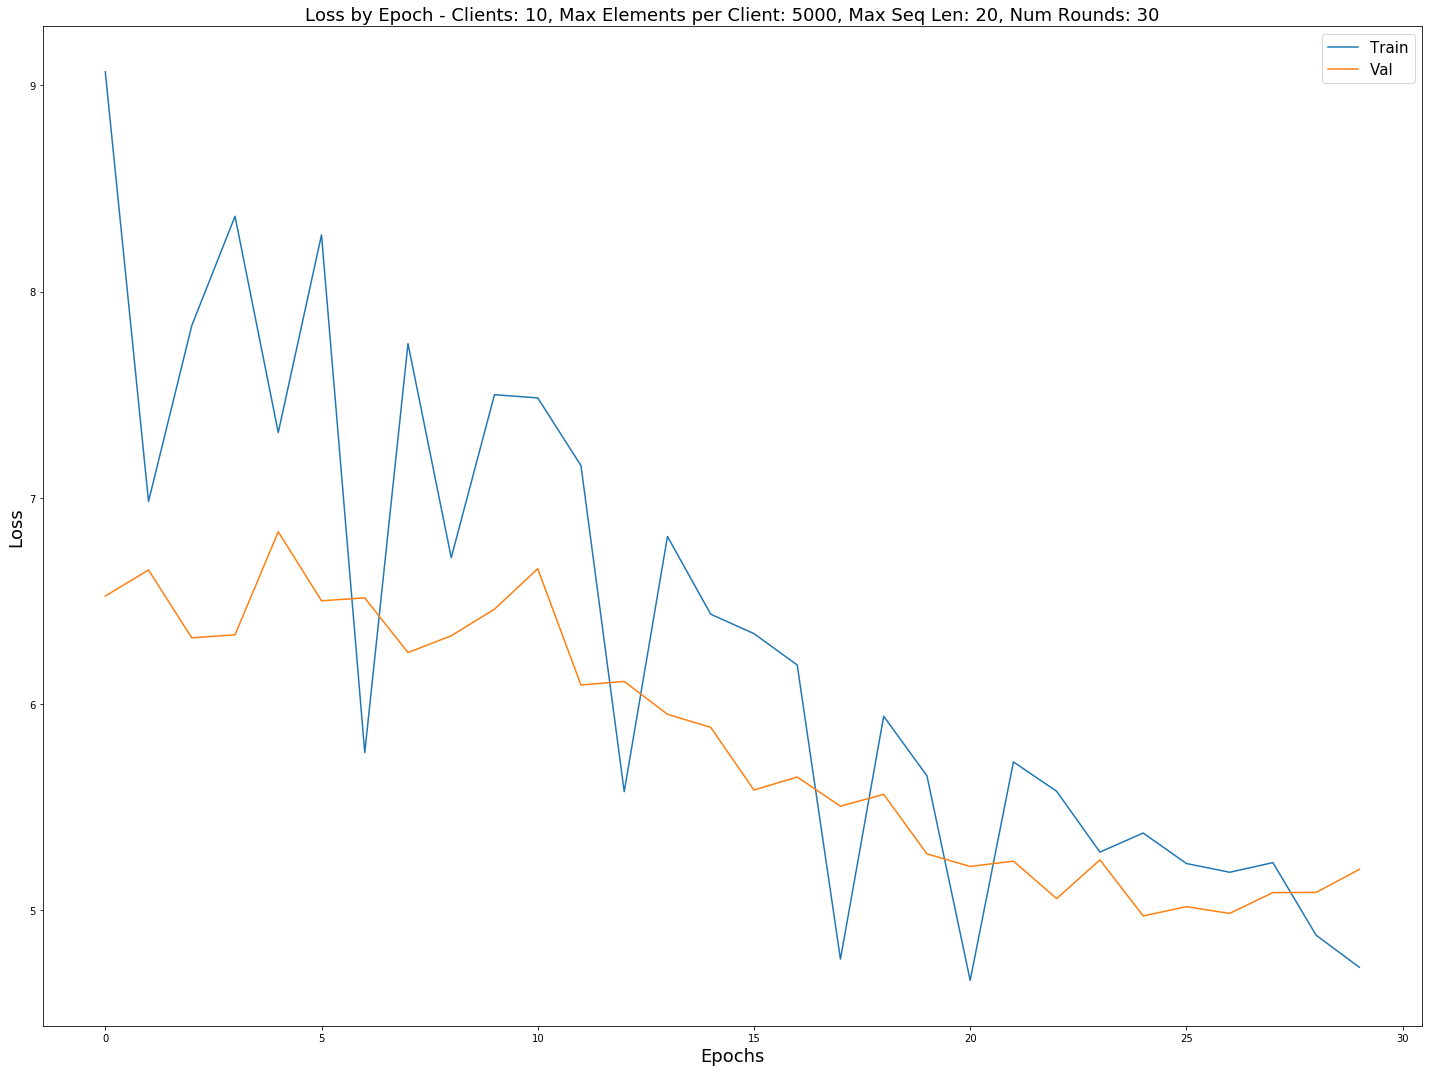

In [19]:
fig, ax = plt.subplots(figsize=(20, 15))
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('loss'), label='Train')
ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('loss'), label='Val')
ax.legend(loc='best', prop={'size': 15})
plt.title('Loss by Epoch - {}'.format(round_config), fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.tight_layout()
plt.savefig(SAV + 'Loss by Epoch.png')
plt.show()

### Plot Train and Validation Accuracy

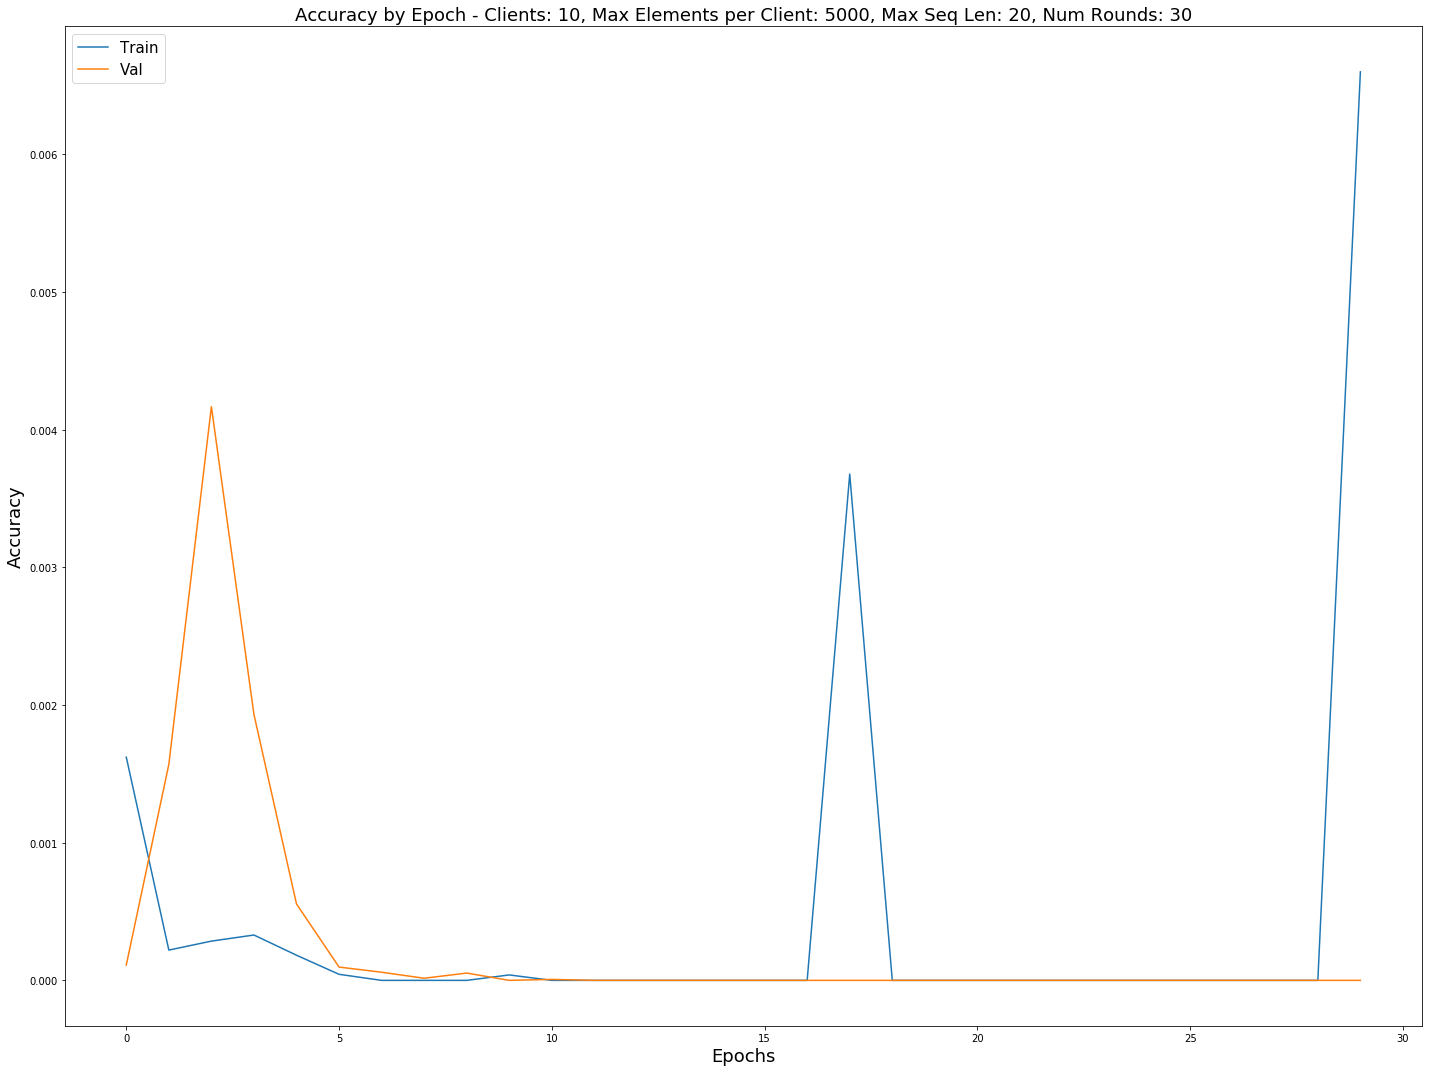

In [20]:
fig, ax = plt.subplots(figsize=(20, 15))
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('accuracy'), label='Train')
ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('accuracy'), label='Val')
ax.legend(loc='best', prop={'size': 15})
plt.title('Accuracy by Epoch - {}'.format(round_config), fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.tight_layout()
plt.savefig(SAV + 'Accuracy by Epoch.png')
plt.show()

### Load Train Sample Stats

In [21]:
examples = np.load(SAV + 'num_examples.npy')
tokens = np.load(SAV + 'num_tokens.npy')
tokens_no_oov = np.load(SAV + 'num_tokens_no_oov.npy')

### Compute Train Sample Means and Standard Deviations

In [22]:
train_sample_stats = ['Examples', 'Tokens', 'Tokens No OOV']
means = [np.mean(examples), np.mean(tokens), np.mean(tokens_no_oov)]
stdvs = [np.std(examples), np.std(tokens), np.std(tokens_no_oov)]

### Plot Train Sample Stats

<Figure size 432x288 with 0 Axes>

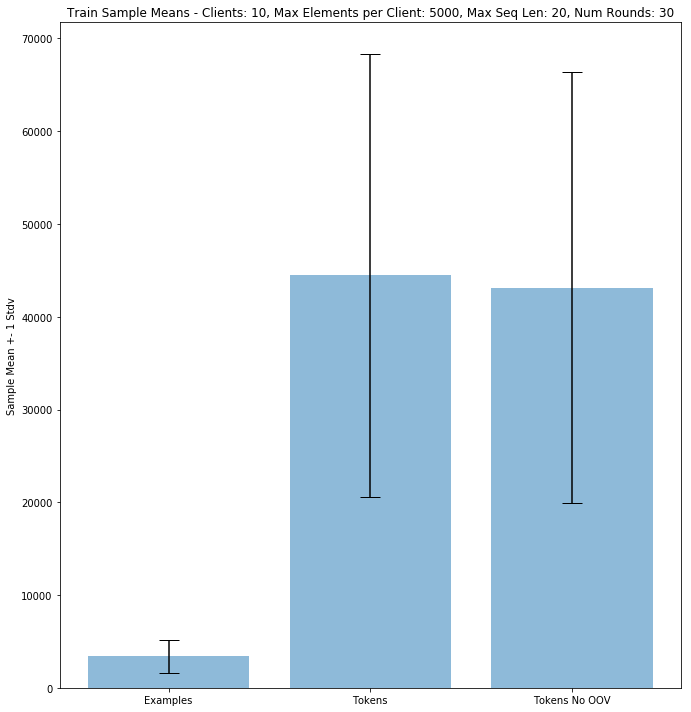

In [23]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
x_pos = np.arange(len(train_sample_stats))
ax.bar(x_pos, means, yerr=stdvs, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Sample Mean +- 1 Stdv')
ax.set_xticks(x_pos)
ax.set_xticklabels(train_sample_stats)
ax.set_title('Train Sample Means - {}'.format(round_config))
plt.tight_layout()
plt.savefig(SAV + '{} Round Train Sample Means.png'.format(NUM_ROUNDS))
plt.show()

<Figure size 432x288 with 0 Axes>

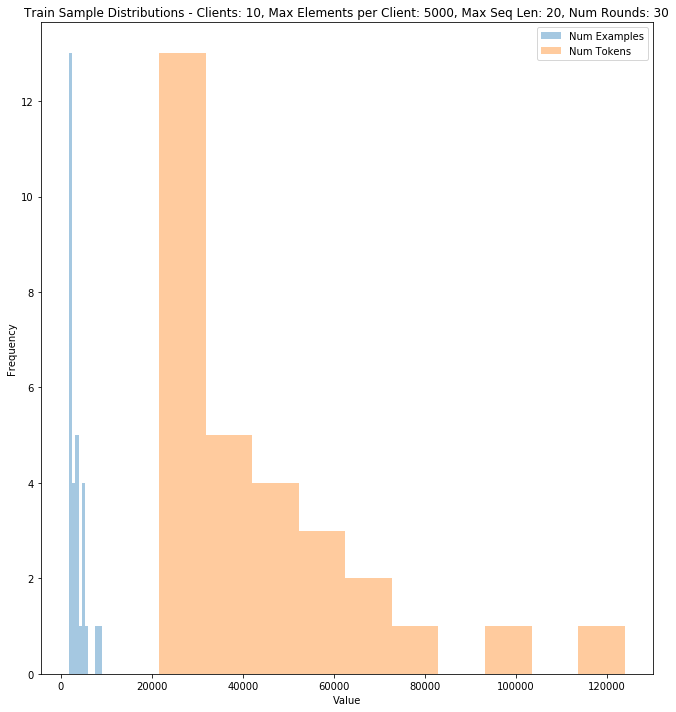

In [24]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(examples, alpha=0.4, label='Num Examples')
plt.hist(tokens, alpha=0.4, label='Num Tokens')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Train Sample Distributions - {}'.format(round_config))
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(SAV + '{} Round Train Sample Distributions.png'.format(NUM_ROUNDS))
plt.show()

<Figure size 432x288 with 0 Axes>

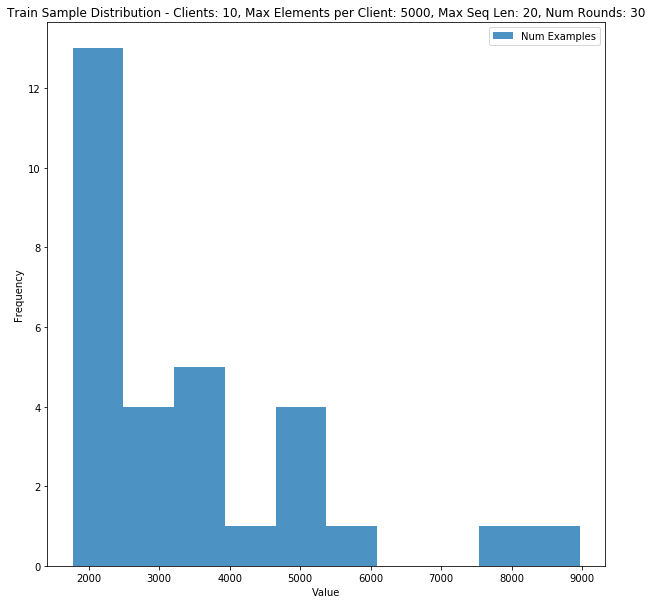

In [25]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(examples, alpha=0.8, label='Num Examples')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Train Sample Distribution - {}'.format(round_config))
plt.legend(loc='best')
plt.show()

<Figure size 432x288 with 0 Axes>

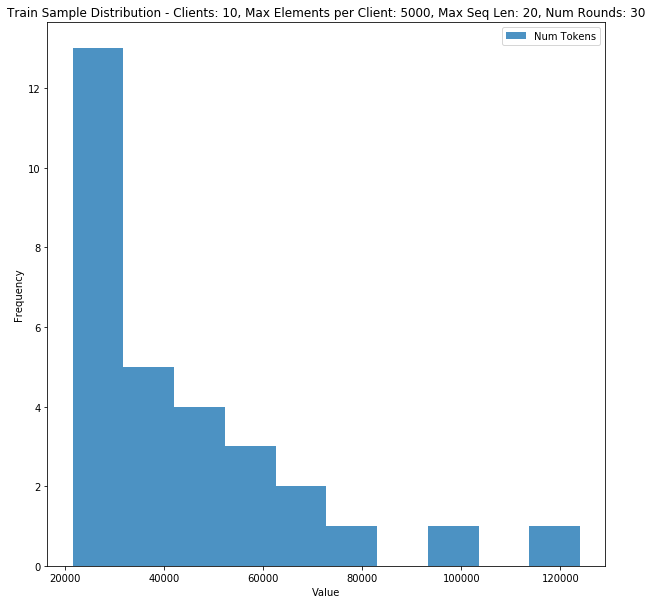

In [26]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(tokens, alpha=0.8, label='Num Tokens')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Train Sample Distribution - {}'.format(round_config))
plt.legend(loc='best')
plt.show()

<Figure size 432x288 with 0 Axes>

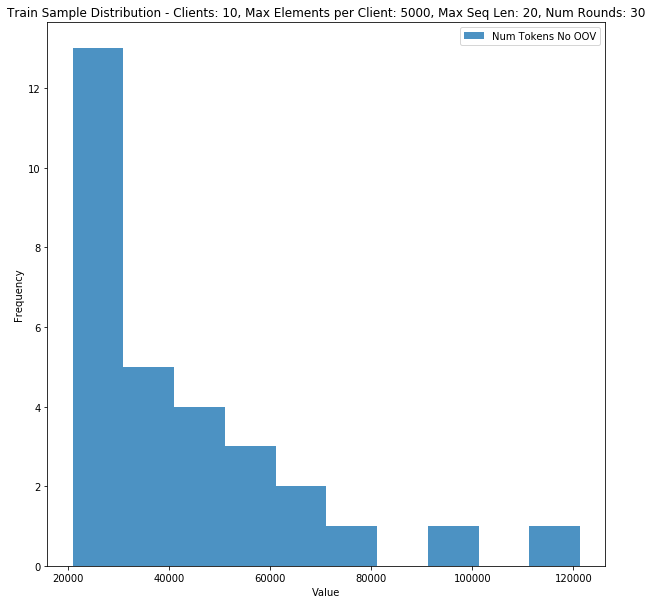

In [27]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(tokens_no_oov, alpha=0.8, label='Num Tokens No OOV')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Train Sample Distribution - {}'.format(round_config))
plt.legend(loc='best')
plt.show()